## Решающие деревья

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Murcha1990/ML_math_2022/blob/main/Семинары/sem11-trees.ipynb)

Это логический алгоритм классификации, решающий задачи классификации и регрессии. Данный алгоритм представляет собой объединение логических условий в структуру дерева.

В зависимости от пространственной структуры данных, один типов моделей из них будет работать лучше:

* Если данные хорошо линейно разделимы,  то линейная модель;
* Если данные линейно неразделимы (присутствуют только кусочно-линейные или нелинейные зависимости), то решающие деревья.


### План семинара:

1. [Задачи](#tasks)
2. [Дерево решений](#decisiontree)
3. [Переобучение](#overfitting)
4. [Неустойчивость](#unstable)
5. [Пример на датасете](#dataset)

### Задачи <a name="tasks"></a>


**Задача 1**. Постройте регрессионное дерево для прогнозирования $y$ с помощью $x$ на обучающей выборке:

||||||
|---|---|---|---|:---:|
|$x_i$|0|1|2|3|
|$y_i$|5|6|4|100|


Критерий деления узла на два — минимизация $RSS$. Дерево строится до трёх терминальных узлов.


**Задача 2**. Постройте регрессионное дерево для прогнозирования $y$ с помощью $x$ на обучающей выборке:

    
|$$y_{i}$$| $$x_{i}$$ |
|:---:|:---:|
|100|1|
|102|2|
|103|3|
|50|4|
|55|5|
|61|6|
|70|7|

Критерий деления узла на два — минимизация $RSS$. Узлы делятся до тех пор, пока в узле остаётся больше двух наблюдений.


**Задача 3**.

Дон-Жуан предпочитает брюнеток. Перед Новым Годом он посчитал, что в записной книжке у него 20 блондинок, 40 брюнеток, две рыжих и восемь шатенок. С Нового Года Дон-Жуан решил перенести все сведения в две записные книжки, в одну — брюнеток, во вторую — остальных.

Как изменились индекс Джини и энтропия в результате такого разбиения?



**Задача 4**.

Приведите примеры наборов данных, для которых индекс Джини равен $0$, $0.5$ и $0.999$.

**Задача 5**.

Машка пять дней подряд гадала на ромашке, а затем выкладывала очередную фотку «Машка с ромашкой» в инстаграмчик. Результат гадания — переменная $y_i$, количество лайков у фотки — переменная $x_i$. Постройте классификационное дерево для прогнозирования $y_i$ с помощью $x_i$ на обучающей выборке:

|$$y_{i}$$| $$x_{i}$$ |
|:---:|:---:|
|плюнет|10|
|поцелует|11|
|поцелует|12|
|к сердцу прижмет|13|
|к сердцу прижмет|14|

Дерево строится до идеальной классификации. Критерий деления узла на два — максимальное падение индекса Джини.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from mlxtend.plotting import plot_decision_regions
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
import pandas as pd

plt.rcParams["figure.figsize"] = (11, 6.5)

### Дерево решений  <a name="decisiontree"></a>


Давайте сгенерируем пример линейно разделимой выборки для задачи бинарной классификации:

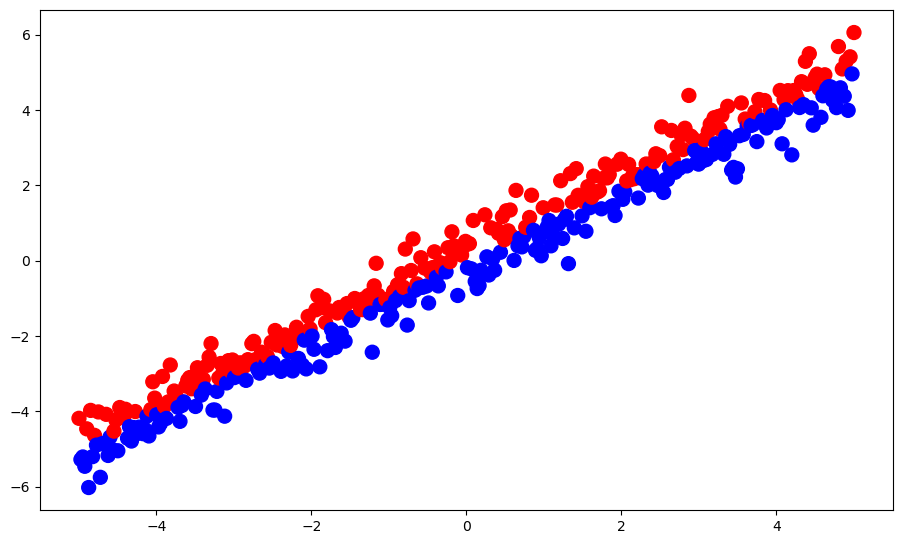

In [2]:
n = 400
np.random.seed(1)
X = np.zeros((n, 2))
X[:, 0] = np.linspace(-5, 5, n)
X[:, 1] = X[:, 0] + 0.5 * np.random.normal(size=n)
y = (X[:, 1] > X[:, 0]).astype(int)

plt.scatter(X[:, 0], X[:, 1], s=100, c=y, cmap='bwr')
plt.show()

Для удобства, напишем функцию для обучения классификатора и построения графика с разделяющей прямой.

In [3]:
def train_model(model=LogisticRegression()):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    plot_decision_regions(X_test, y_test, model)
    plt.show()

    print(f"Accuracy: {accuracy_score(y_pred, y_test):.2f}")

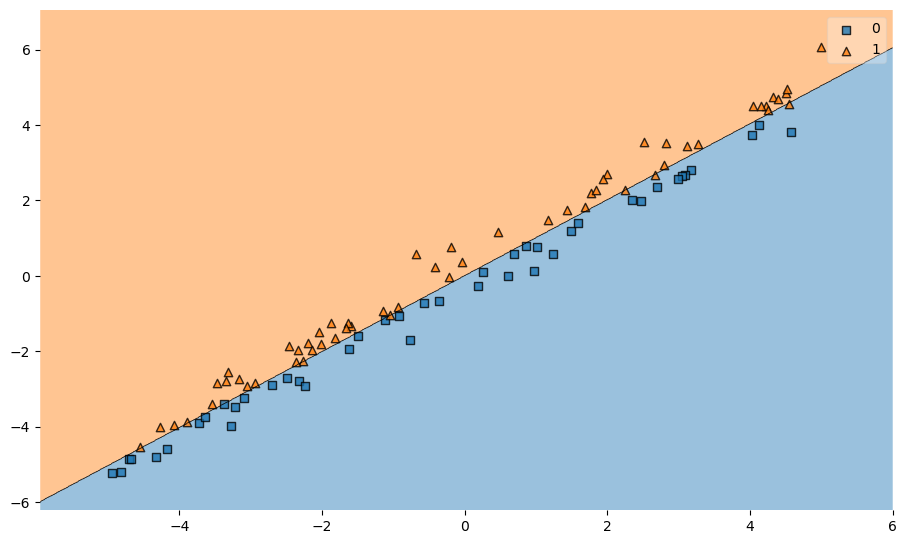

Accuracy: 0.98


In [4]:
train_model(LogisticRegression())

Сравним качество, так ли хорошо получится решить эту задачу не логитической регрессией, а деревом решений на линейно разделимой выборке?

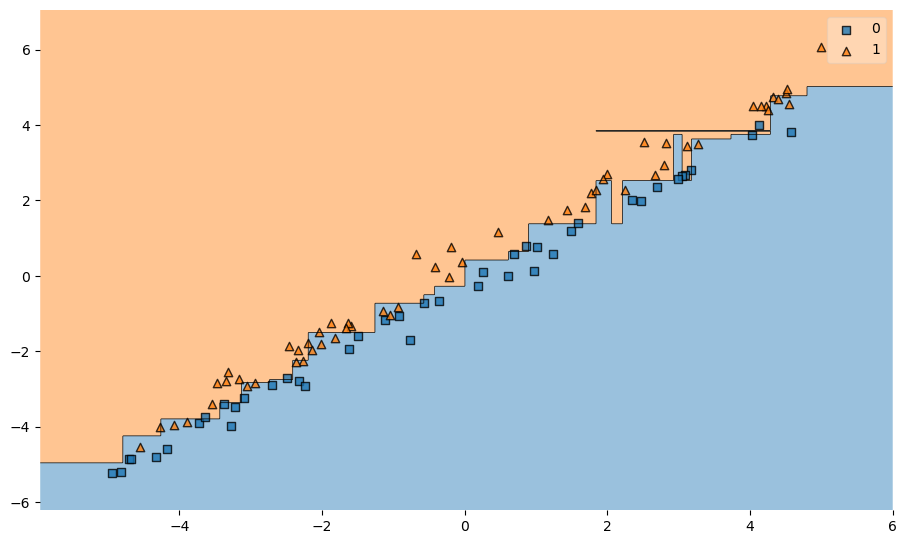

Accuracy: 0.74


In [5]:
train_model(DecisionTreeClassifier(random_state=13))

Давайте вспомним, что такое логическое исключающее ИЛИ, и сгенерируем пример выборки. 

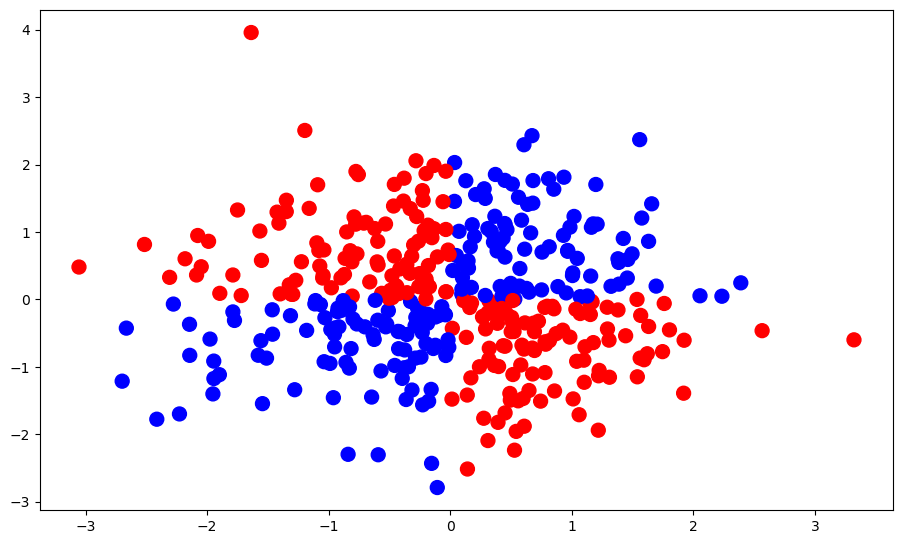

In [6]:
X = np.random.randn(n, 2)
y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0).astype(int)
plt.scatter(X[:, 0], X[:, 1], s=100, c=y, cmap="bwr")
plt.show()

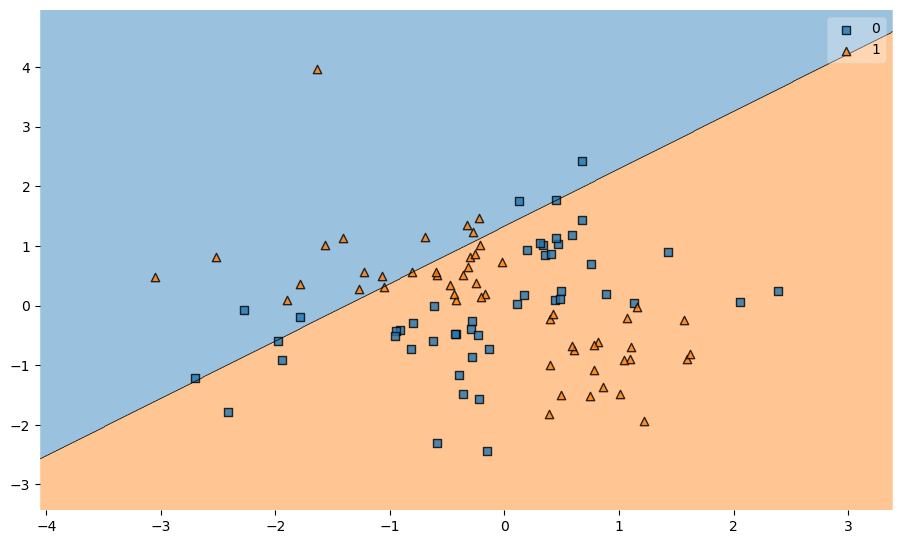

Accuracy: 0.43


In [7]:
train_model(LogisticRegression())

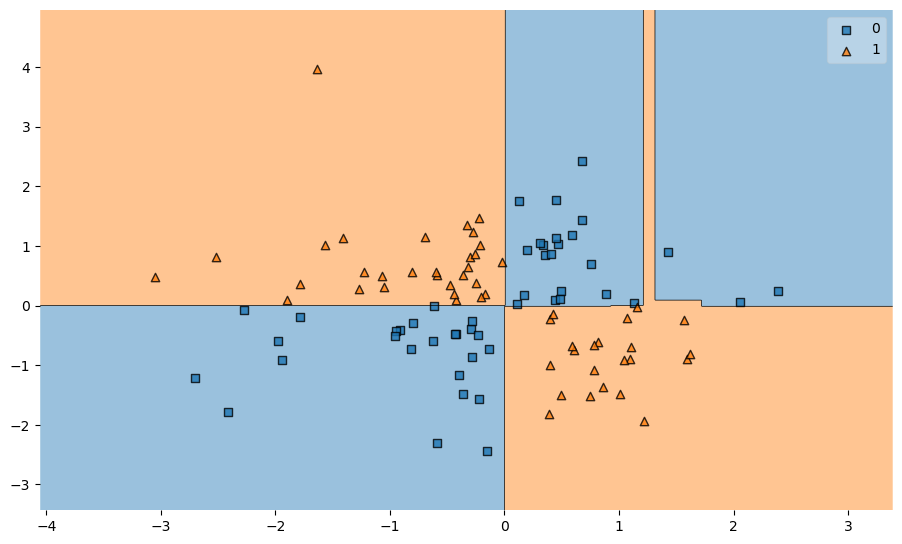

Accuracy: 1.00


In [8]:
train_model(DecisionTreeClassifier())

### Переобучение <a name="overfitting"></a>

Решающие деревья могут переобучаться под любую выборку, если их не регуляризовать: при большом количестве листьев для каждого объекта может выделиться своя область в признаковом пространстве. Дерево просто выучивает обучающую выборку, но не выделяет закономерности в данных. Давайте убедимся в этом на практике.

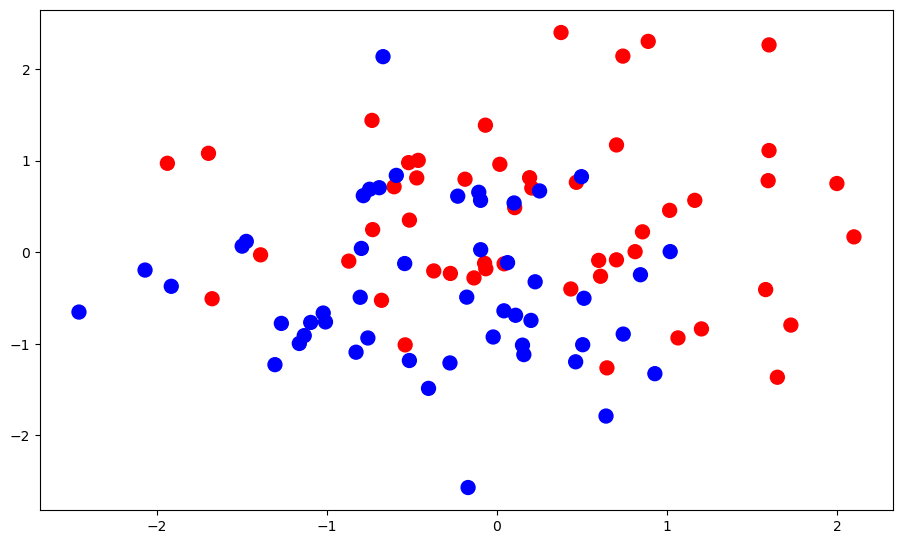

In [9]:
np.random.seed(13)
n = 100
X = np.random.normal(size=(n, 2))
X[:50, :] += 0.25
X[50:, :] -= 0.25
y = np.array([1] * 50 + [0] * 50)
plt.scatter(X[:, 0], X[:, 1], s=100, c=y, cmap="bwr")
plt.show()

Проверим, как разные значения гиперпараметров решающего дерева влияют на его структуру:

- `max_depth`: максимальная глубина дерева
- `min_samples_leaf`: минимальное число объектов в вершине дерева, необходимое для того, чтобы она стала листом

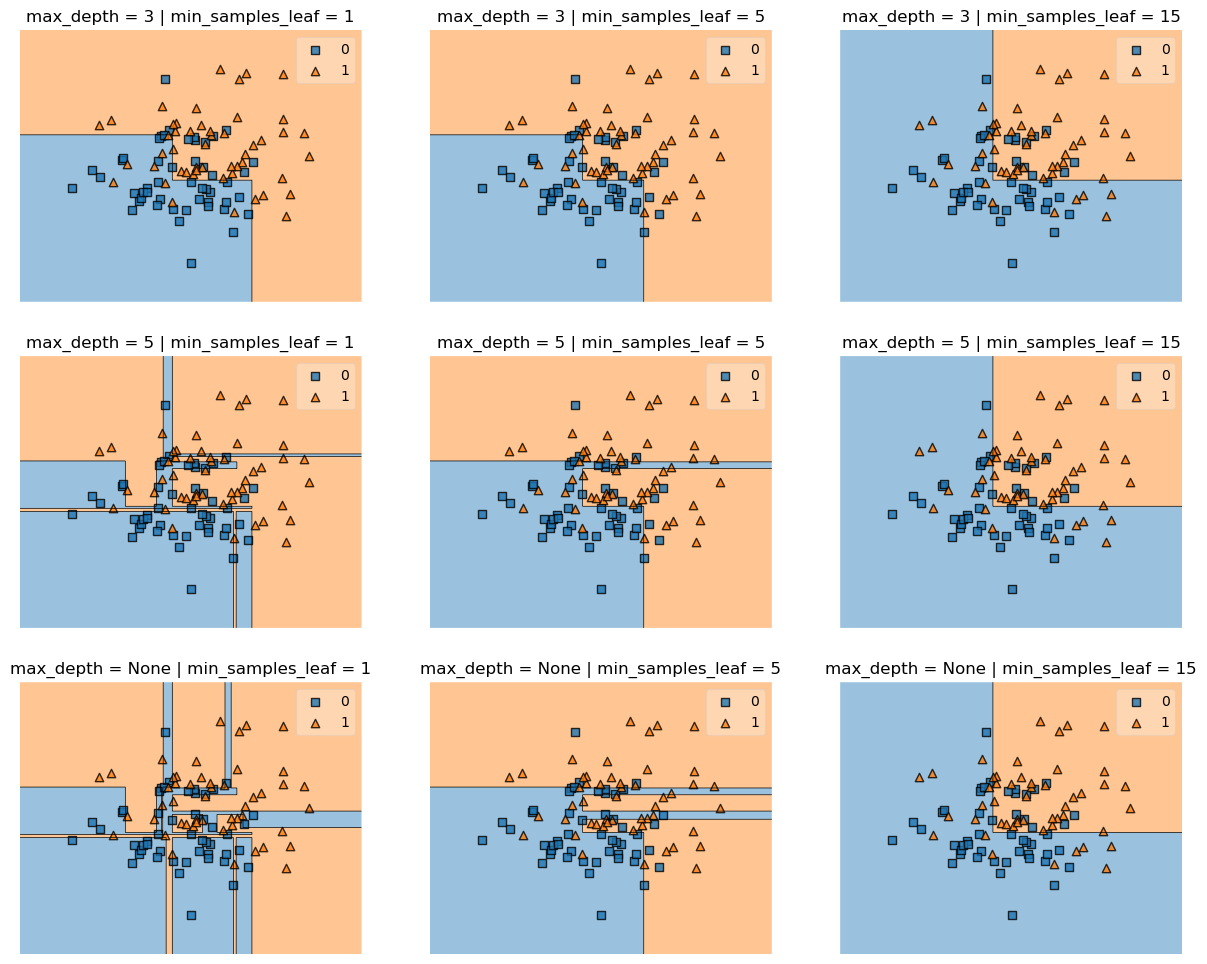

In [10]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))

for i, max_depth in enumerate([3, 5, None]):
    for j, min_samples_leaf in enumerate([1, 5, 15]):
        dt = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=13)
        dt.fit(X, y)
        ax[i][j].set_title("max_depth = {} | min_samples_leaf = {}".format(max_depth, min_samples_leaf))
        ax[i][j].axis("off")
        plot_decision_regions(X, y, dt, ax=ax[i][j])
        
plt.show()

На любой выборке (исключая те, где есть объекты с одинаковыми значениями признаков, но разными ответами) можно получить нулевую ошибку - с помощью максимально переобученного дерева:

Accuracy: 0.74


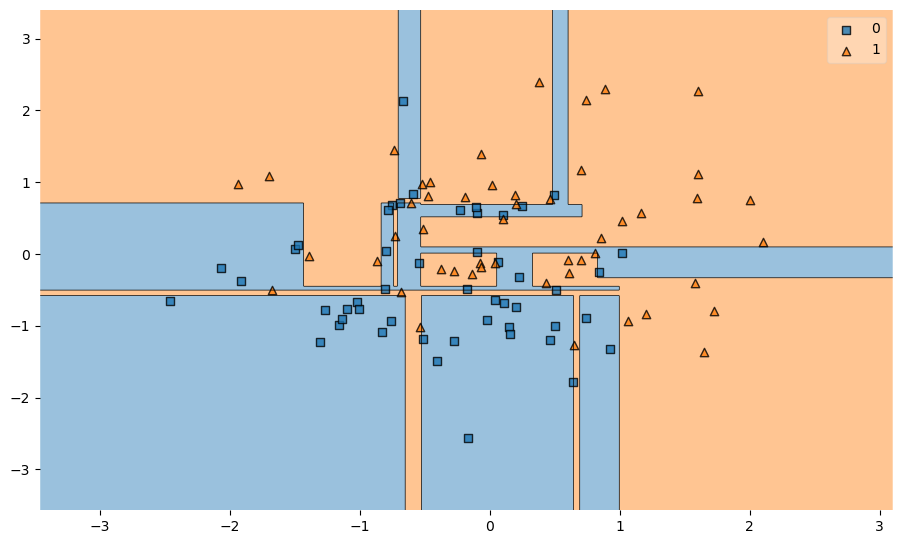

In [11]:
model = DecisionTreeClassifier(max_depth=None, min_samples_leaf=1, random_state=13)
model.fit(X, y)

print(f"Accuracy: {accuracy_score(y, dt.predict(X)):.2f}")

plot_decision_regions(X, y, model)
plt.show()

### Неустойчивость  <a name="unstable"></a>

Как будет меняться структура дерева, если брать для обучения разные 90%-ые подвыборки из исходной?

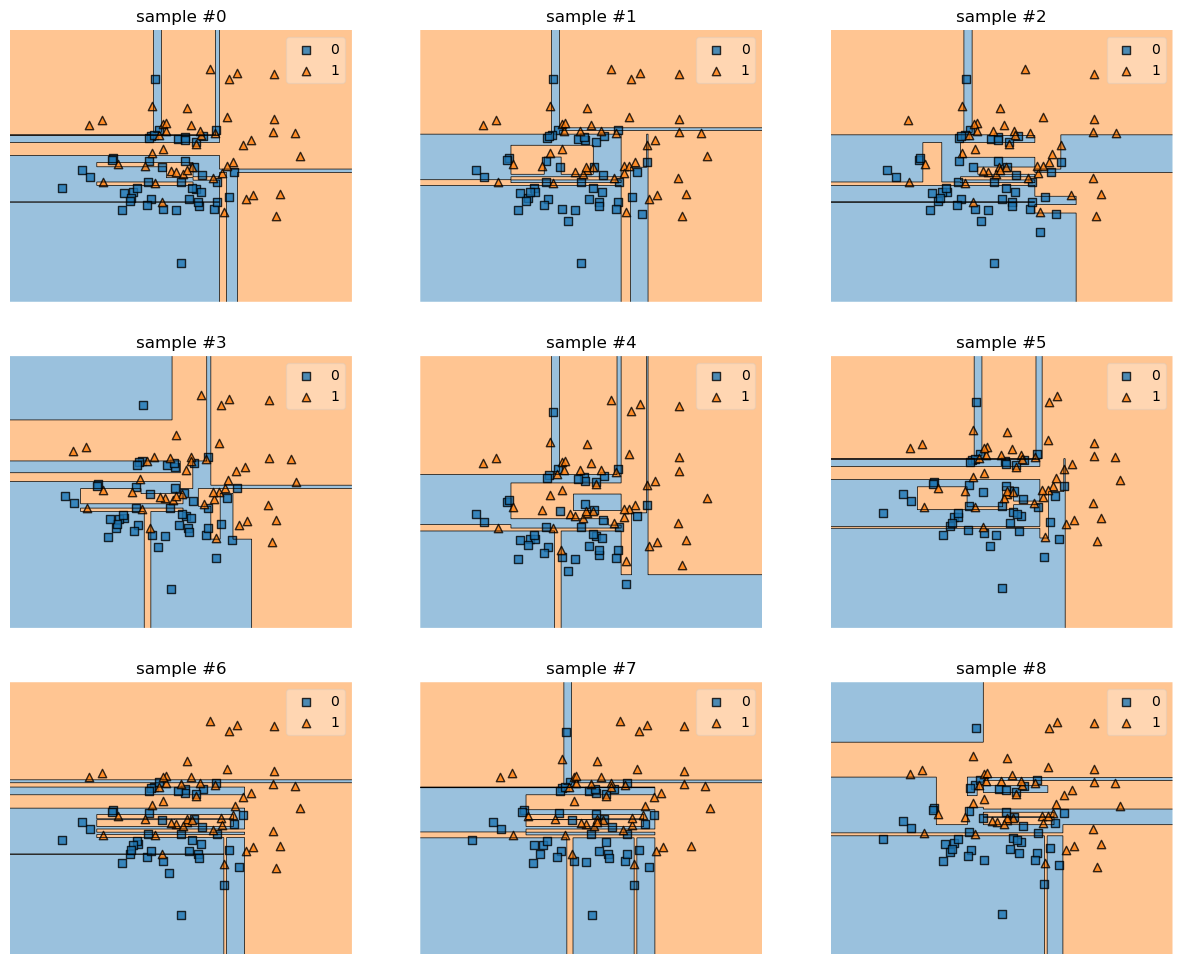

In [12]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))

for i in range(3):
    for j in range(3):
        seed_idx = 3 * i + j
        np.random.seed(seed_idx)
        dt = DecisionTreeClassifier(random_state=13)
        idx_part = np.random.choice(len(X), replace=False, size=int(0.9 * len(X)))
        X_part, y_part = X[idx_part, :], y[idx_part]
        dt.fit(X_part, y_part)
        ax[i][j].set_title("sample #{}".format(seed_idx))
        ax[i][j].axis("off")
        plot_decision_regions(X_part, y_part, dt, ax=ax[i][j])
        
plt.show()

### Датасет  <a name="dataset"></a>

Построим решающее дерево для какого-нибудь набора данных.

In [14]:
dataset = fetch_california_housing()
print(dataset["DESCR"])

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [15]:
X = pd.DataFrame(data=dataset["data"], columns=dataset["feature_names"])
y = dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

print(f"Shape: {X.shape}")
X.head()

Shape: (20640, 8)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


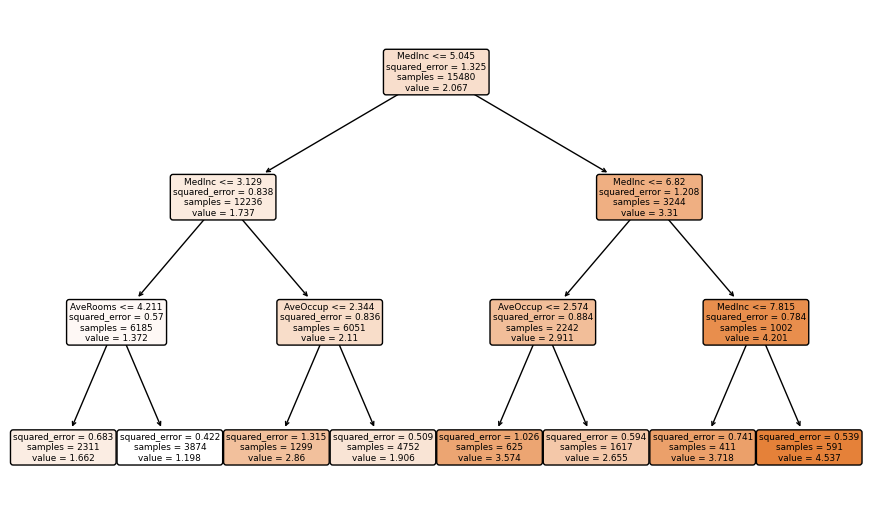

In [16]:
tree = DecisionTreeRegressor(max_depth=3, random_state=13)
tree.fit(X_train, y_train)

plot_tree(tree, feature_names=X.columns, filled=True, rounded=True)
plt.show()

In [17]:
round(mean_squared_error(y_test, tree.predict(X_test)), 1)

0.6

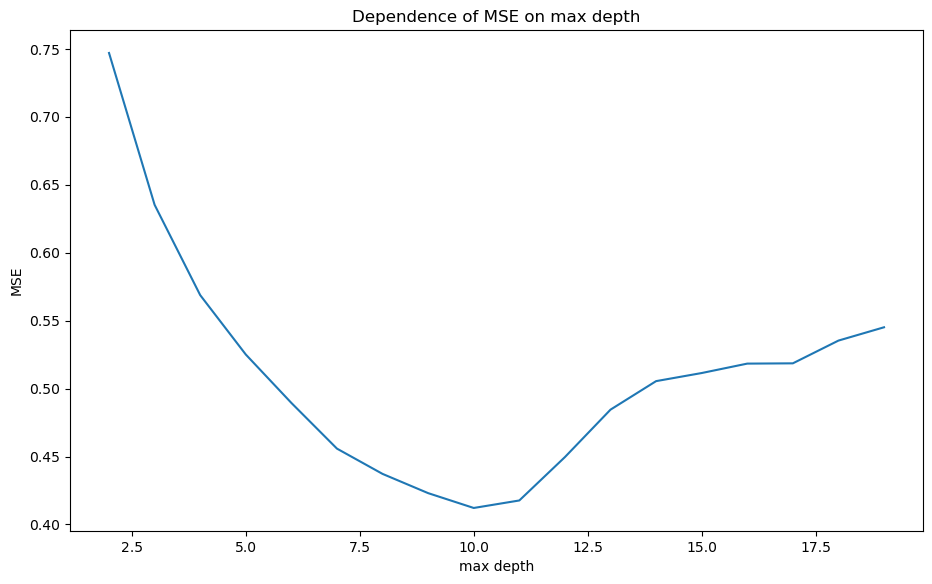

In [18]:
max_depth_array = range(2, 20)
mse_array = []

for max_depth in max_depth_array:
    tree = DecisionTreeRegressor(max_depth=max_depth, random_state=13)
    tree.fit(X_train, y_train)
    mse_array.append(mean_squared_error(y_test, tree.predict(X_test)))

plt.plot(max_depth_array, mse_array)
plt.title("Dependence of MSE on max depth")
plt.xlabel("max depth")
plt.ylabel("MSE")
plt.show()

In [19]:
pd.DataFrame({"max_depth": max_depth_array,"MSE": mse_array}).sort_values(by="MSE").reset_index(drop=True)[:5]

,max_depth,MSE
0,10,0.412125
1,11,0.417647
2,9,0.423044
3,8,0.437202
4,12,0.449578


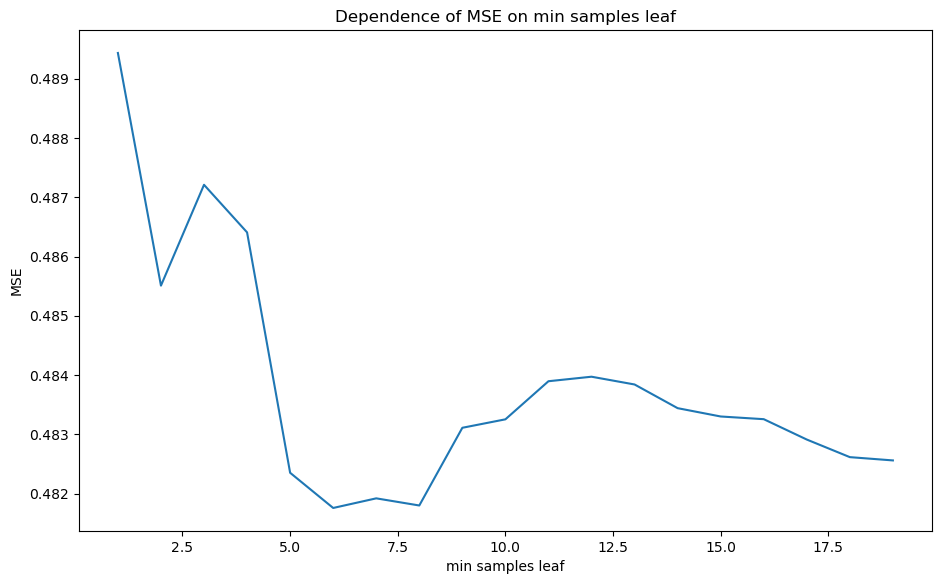

In [20]:
min_samples_leaf_array = range(1, 20)
mse_array = []

for min_samples_leaf in min_samples_leaf_array:
    dt = DecisionTreeRegressor(max_depth=6, min_samples_leaf=min_samples_leaf, random_state=13)
    dt.fit(X_train, y_train)
    mse_array.append(mean_squared_error(y_test, dt.predict(X_test)))
    
plt.plot(min_samples_leaf_array, mse_array)
plt.title("Dependence of MSE on min samples leaf")
plt.xlabel("min samples leaf")
plt.ylabel("MSE")
plt.show()

In [21]:
pd.DataFrame({"min_samples_leaf": min_samples_leaf_array,"MSE": mse_array}).sort_values(by="MSE").reset_index(drop=True)[:5]

,min_samples_leaf,MSE
0,6,0.481757
1,8,0.481799
2,7,0.481919
3,5,0.482351
4,19,0.482560


## Бонус: решающее дерево своими руками

$R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения.

Критерий ошибки:

$$
Q(R_m, j, t) = \frac{|R_\ell|}{|R_m|}H(R_\ell) + \frac{|R_r|}{|R_m|}H(R_r) \to \min_{j, t}
$$

$R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

$H(R)$ - критерий информативности, с помощью которого можно оценить качество распределения целевой переменной среди объектов множества $R$.

_Реализуйте подсчет критерия ошибки. Для этого реализуйте функции для подсчета значения критерия информативности, а также для разбиения вершины._

In [24]:
dataset = fetch_california_housing()
X = pd.DataFrame(data=dataset["data"], columns=dataset["feature_names"])
X["target"] = dataset["target"]

X_train, X_test = train_test_split(X, test_size=0.25, random_state=13)

In [25]:
from typing import Iterable, List, Tuple

def H(R: pd.DataFrame) -> float:
    """
    Compute impurity criterion for a fixed set of objects R.
    Last column is assumed to contain target value
    """
    return R["target"].var()


def split_node(R_m: np.ndarray, feature: str, t: float) -> Tuple[np.ndarray, np.ndarray]:
    """
    Split a fixed set of objects R_m given feature number and threshold t
    """
    mask = R_m[feature] <= t
    return R_m.loc[mask], R_m.loc[~mask]


def q_error(R_m: np.ndarray, feature: str, t: float) -> float:
    """
    Compute error criterion for given split parameters
    """
    R_l, R_r = split_node(R_m, feature, t)
    return len(R_l) / len(R_m) * H(R_l) + len(R_r) / len(R_m) * H(R_r)

_Переберите все возможные разбиения выборки по одному из признаков и постройте график критерия ошибки в зависимости от значения порога._

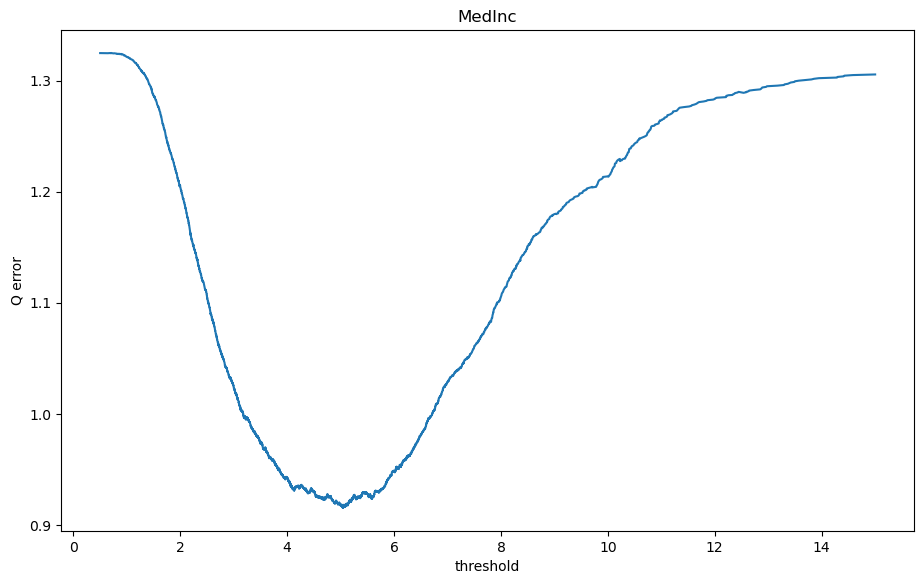

In [30]:
feature = "MedInc"
Q_array = []

feature_values = np.unique(X_train[feature])
for t in feature_values:
    Q_array.append(q_error(X_train, feature, t))

plt.plot(feature_values, Q_array)
plt.title(feature)
plt.xlabel("threshold")
plt.ylabel("Q error")
plt.show()

_Напишите функцию, находящую оптимальное разбиение данной вершины по данному признаку._

In [31]:
def get_optimal_split(R_m: np.array, feature: str) -> Tuple[float, List[float]]:
    Q_array = []
    feature_values = np.unique(R_m[feature])
    
    for t in feature_values:
        Q_array.append(q_error(R_m, feature, t))
        
    Q_array = np.nan_to_num(Q_array, nan=float("+inf"))
        
    opt_threshold = feature_values[np.argmin(Q_array)]
    
    return opt_threshold, Q_array

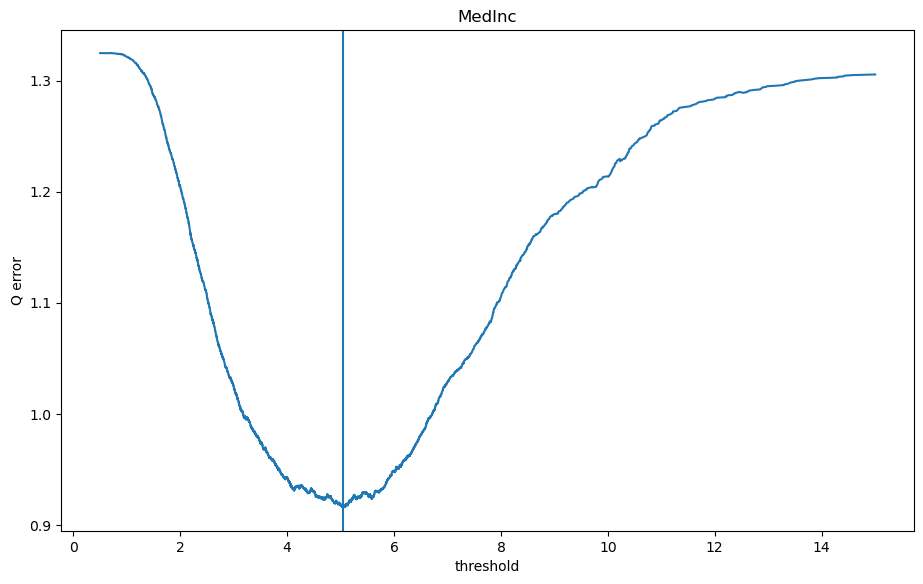

In [32]:
t, Q_array = get_optimal_split(X_train, feature)
plt.plot(np.unique(X_train[feature]), Q_array)
plt.title(feature)
plt.xlabel("threshold")
plt.ylabel("Q error")
plt.axvline(x=t)
plt.show()

_Постройте графики критерия ошибки (в зависимости от количества объектов в левом поддереве) для каждого из признаков. Найдите признак, показывающий наилучшее качество. Какой это признак? Каков порог разбиения и значение качества? Постройте график критерия ошибки для данного признака в зависимости от значения порога._

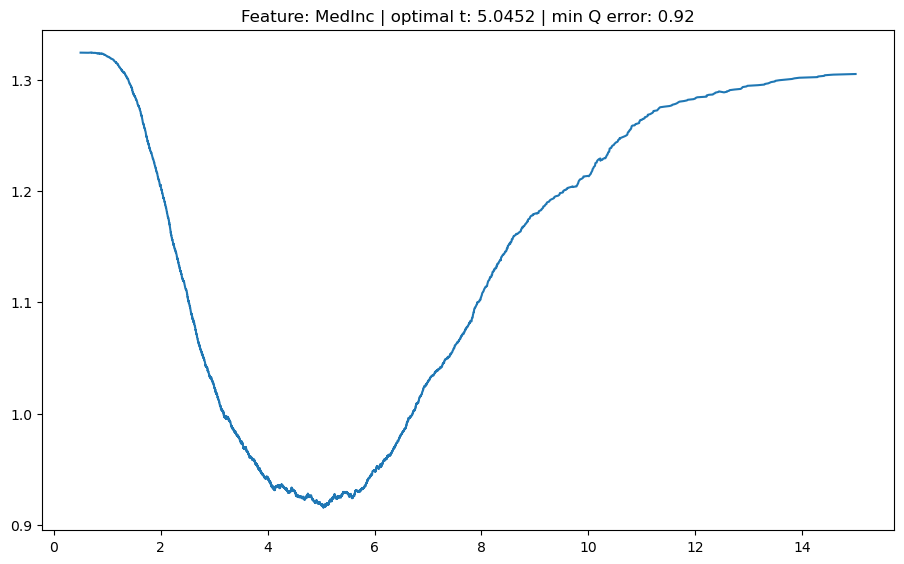

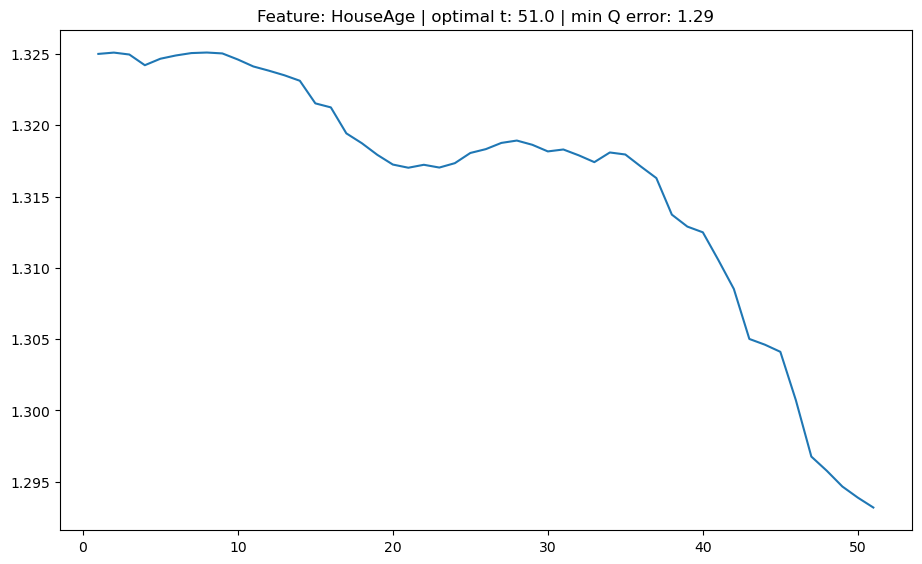

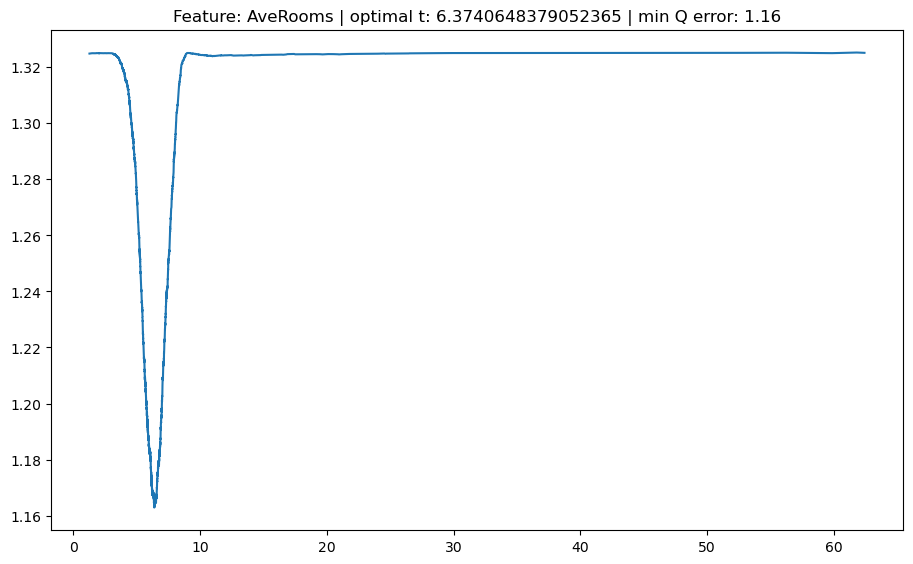

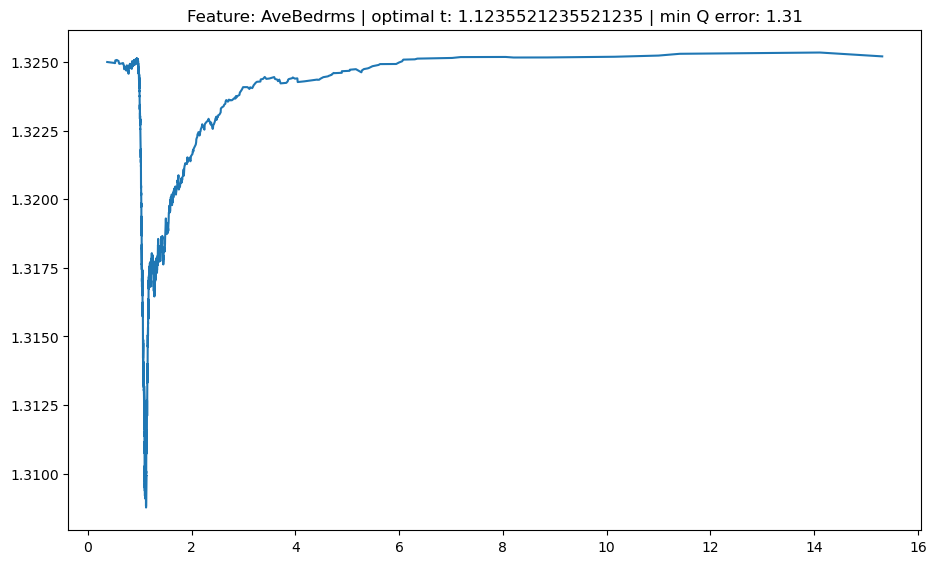

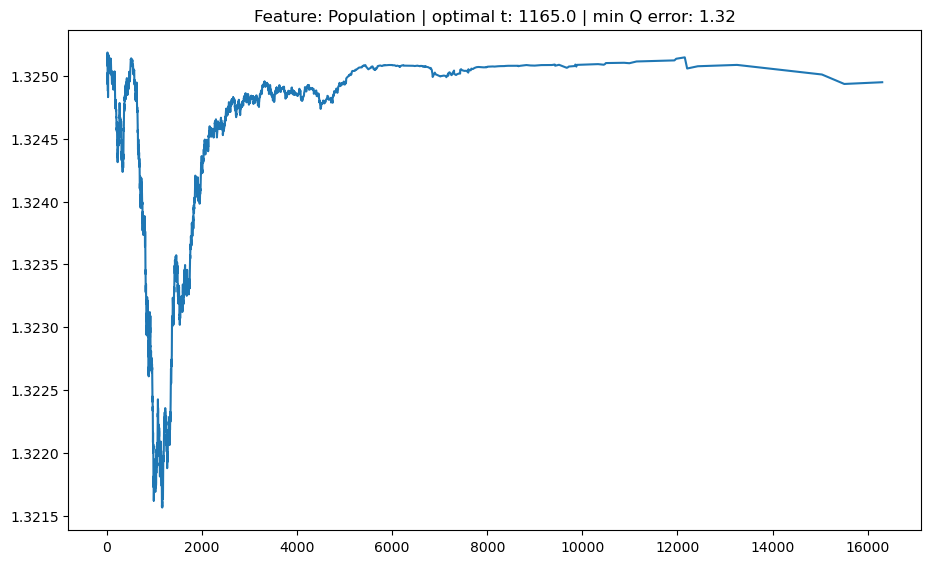

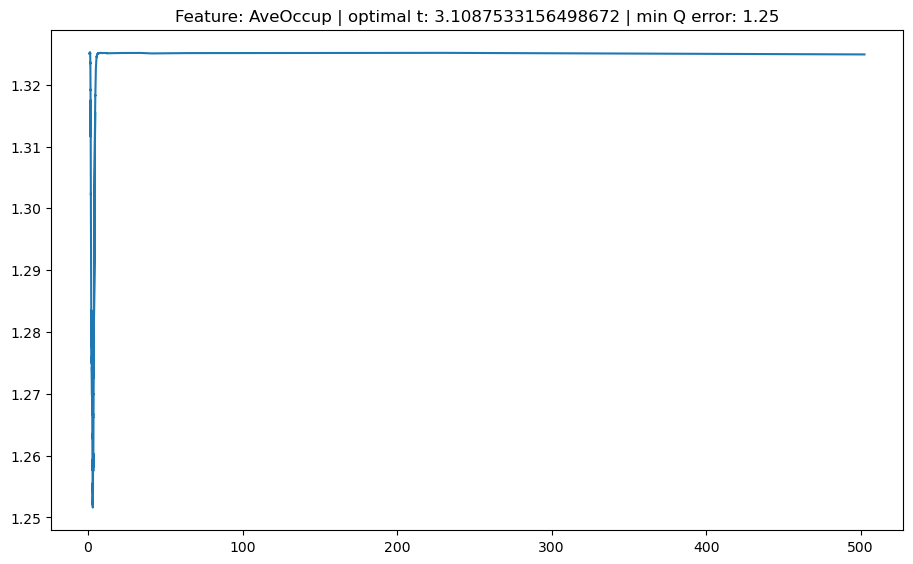

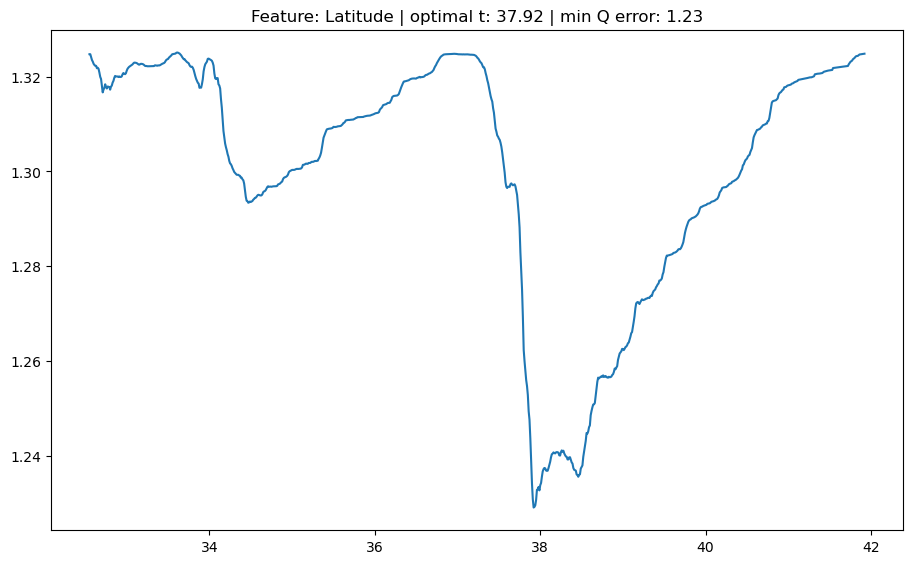

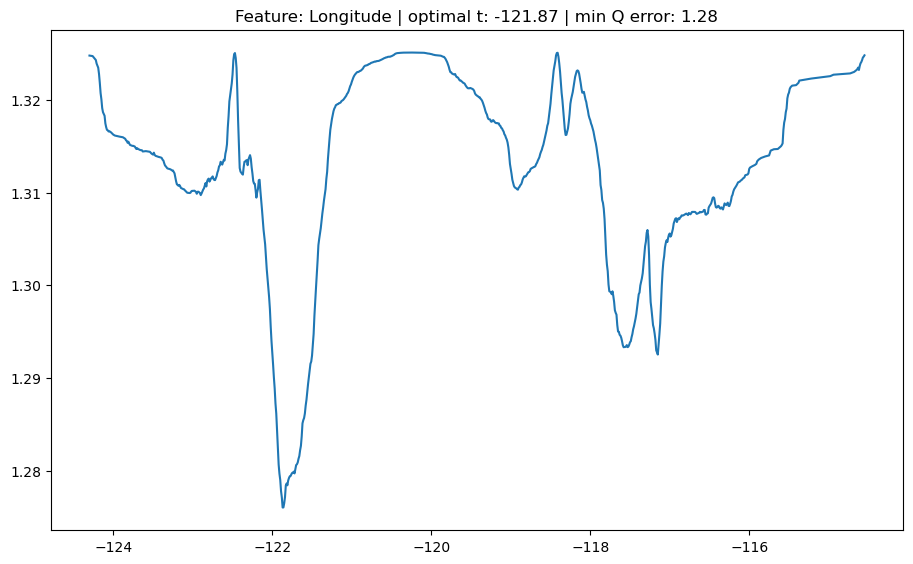

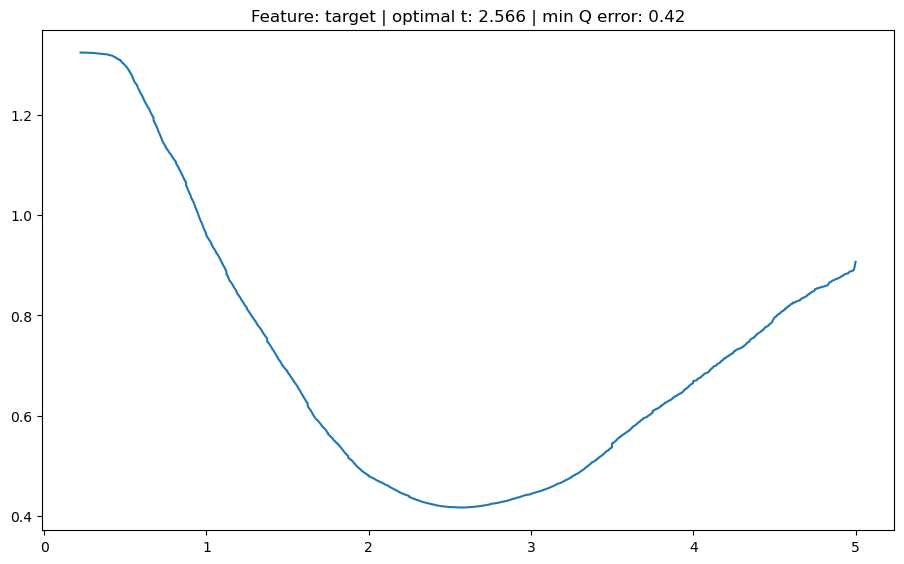

[('target', 2.566, 0.4171876297492328),
 ('MedInc', 5.0452, 0.9153642142848055),
 ('AveRooms', 6.3740648379052365, 1.1628589971272478),
 ('Latitude', 37.92, 1.229030378207104),
 ('AveOccup', 3.1087533156498672, 1.2516106017878255),
 ('Longitude', -121.87, 1.2760115799735559),
 ('HouseAge', 51.0, 1.293194095905453),
 ('AveBedrms', 1.1235521235521235, 1.308769985755053),
 ('Population', 1165.0, 1.321564360257149)]

In [33]:
results = []

for f in X_train.columns:
    t, Q_array = get_optimal_split(X_train, f)
    min_error = min(Q_array)
    results.append((f, t, min_error))
    plt.figure()
    plt.title("Feature: {} | optimal t: {} | min Q error: {:.2f}".format(f, t, min_error))
    plt.plot(np.unique(X_train[f]), Q_array)
    plt.show()
    
results = sorted(results, key=lambda x: x[2])
results

In [34]:
pd.DataFrame(results, columns=["feature", "optimal t", "min Q error"])

,feature,optimal t,min Q error
0,target,2.566000,0.417188
1,MedInc,5.045200,0.915364
2,AveRooms,6.374065,1.162859
3,Latitude,37.920000,1.229030
4,AveOccup,3.108753,1.251611
5,Longitude,-121.870000,1.276012
6,HouseAge,51.000000,1.293194
7,AveBedrms,1.123552,1.308770
8,Population,1165.000000,1.321564


In [35]:
optimal_feature, optimal_t, optimal_error = results[1]

In [36]:
print(optimal_feature)
print(optimal_t)
print(optimal_error)

MedInc
5.0452
0.9153642142848055


_Изобразите разбиение визуально. Для этого постройте диаграмму рассеяния целевой переменной в зависимости от значения найденного признака. Далее изобразите вертикальную линию, соответствующую порогу разбиения. Почему это разбиение может быть лучшим? Как вы можете интерпретировать результат?_

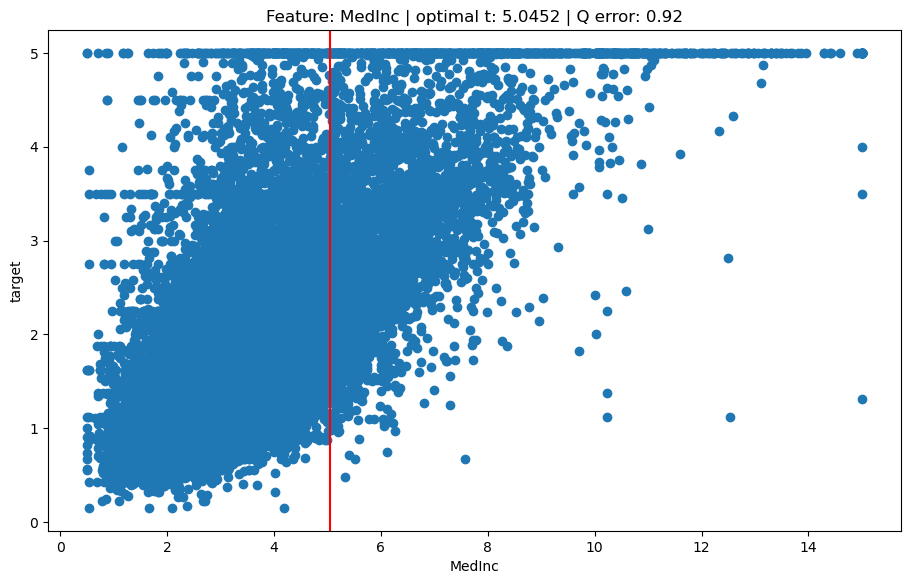

In [37]:
plt.scatter(X[optimal_feature], y)
plt.axvline(x=optimal_t, color="red")
plt.xlabel(optimal_feature)
plt.ylabel("target")
plt.title("Feature: {} | optimal t: {} | Q error: {:.2f}".format(optimal_feature, optimal_t, optimal_error))
plt.show()

## Бонус

Здесь можно посмотреть, как работает стрижка (cost-complexity pruning) для снижения переобучения деревьев: [ноутбук](https://colab.research.google.com/drive/1SGGaIGgo1wOsvBdPfiBb0128emHnu3Oo?usp=sharing).